## Improving Predictions with `scikit-learn`

In this chapter we will try the same regression as chapter 8, but this time without departure delay; a harder problem.

In [1]:
import sys, os, re
sys.path.append("lib")
import utils

import numpy as np
import sklearn
import iso8601
import datetime
print("Imports loaded...")

Imports loaded...


In [2]:
# Load and check the size of our training data. May take a minute.
print("Original JSON file size: {:,} Bytes".format(os.path.getsize("../data/simple_flight_delay_features.jsonl")))
training_data = utils.read_json_lines_file('../data/simple_flight_delay_features.jsonl')
print("Training items: {:,}".format(len(training_data))) # 457,013
print("Data loaded...")

Original JSON file size: 45,056 Bytes
Training items: 457,013
Data loaded...


In [3]:
# Inspect a record before we alter them
print("Size of training data in RAM: {:,} Bytes".format(sys.getsizeof(training_data))) # 4MB
print(training_data[0])

Size of training data in RAM: 4,018,008 Bytes
{'ArrDelay': 4.0, 'CRSArrTime': '2015-01-19T14:54:00.000Z', 'CRSDepTime': '2015-01-19T12:40:00.000Z', 'Carrier': 'US', 'DayOfMonth': 19, 'DayOfWeek': 1, 'DayOfYear': 19, 'DepDelay': -1.0, 'Dest': 'PHX', 'Distance': 338.0, 'FlightDate': '2015-01-19T00:00:00.000Z', 'FlightNum': '1712', 'Origin': 'SNA'}


In [4]:
# # We need to sample our data to fit into RAM
# training_data = np.random.choice(training_data, 1000000) # 'Sample down to 1MM examples'
# print("Sampled items: {:,} Bytes".format(len(training_data)))
# print("Data sampled...")

In [5]:
# Separate our results from the rest of the data, vectorize and size up
results = [record['ArrDelay'] for record in training_data]
results_vector = np.array(results)
print("Results vectorized size: {:,}".format(sys.getsizeof(results_vector))) # 3,656,200 bytes
print("Results vectorized...")

Results vectorized size: 3,656,200
Results vectorized...


In [6]:
# Remove the two delay fields and the flight date from our training data
for item in training_data:
  item.pop('ArrDelay', None)
  item.pop('FlightDate', None)
  item.pop('DepDelay', None)
print("ArrDelay, DepDelay and FlightDate removed from training data...")

ArrDelay, DepDelay and FlightDate removed from training data...


In [7]:
# Must convert datetime strings to unix times
for item in training_data:
  if isinstance(item['CRSArrTime'], str):
    dt = iso8601.parse_date(item['CRSArrTime'])
    unix_time = int(dt.timestamp())
    item['CRSArrTime'] = unix_time
  if isinstance(item['CRSDepTime'], str):
    dt = iso8601.parse_date(item['CRSDepTime'])
    unix_time = int(dt.timestamp())
    item['CRSDepTime'] = unix_time
print("CRSArr/DepTime converted to unix time...")

CRSArr/DepTime converted to unix time...


In [17]:
# Use DictVectorizer to convert feature dicts to vectors
from sklearn.feature_extraction import DictVectorizer

print("Sampled dimensions: [{:,}]".format(len(training_data)))
vectorizer = DictVectorizer()
training_vectors = vectorizer.fit_transform(training_data)
print("Size of DictVectorized vectors: {:,} Bytes".format(training_vectors.data.nbytes))
print(training_vectors)
print("Training data vectorized...")

Sampled dimensions: [457,013]
Size of DictVectorized vectors: 36,561,040 Bytes
  (0, 0)	1421679240.0
  (0, 1)	1421671200.0
  (0, 13)	1.0
  (0, 16)	19.0
  (0, 17)	1.0
  (0, 18)	19.0
  (0, 249)	1.0
  (0, 331)	338.0
  (0, 1122)	1.0
  (0, 6946)	1.0
  (1, 0)	1421669640.0
  (1, 1)	1421661600.0
  (1, 13)	1.0
  (1, 16)	19.0
  (1, 17)	1.0
  (1, 18)	19.0
  (1, 249)	1.0
  (1, 331)	338.0
  (1, 4727)	1.0
  (1, 6946)	1.0
  (2, 0)	1421703900.0
  (2, 1)	1421695800.0
  (2, 13)	1.0
  (2, 16)	19.0
  (2, 17)	1.0
  :	:
  (457010, 18)	11.0
  (457010, 287)	1.0
  (457010, 331)	987.0
  (457010, 5237)	1.0
  (457010, 6907)	1.0
  (457011, 0)	1420965000.0
  (457011, 1)	1420959600.0
  (457011, 3)	1.0
  (457011, 16)	11.0
  (457011, 17)	7.0
  (457011, 18)	11.0
  (457011, 288)	1.0
  (457011, 331)	421.0
  (457011, 2657)	1.0
  (457011, 6907)	1.0
  (457012, 0)	1421002200.0
  (457012, 1)	1420996800.0
  (457012, 3)	1.0
  (457012, 16)	11.0
  (457012, 17)	7.0
  (457012, 18)	11.0
  (457012, 288)	1.0
  (457012, 331)	421.0
  (4

In [9]:
from sklearn.model_selection import train_test_split
# Redo test/train split
X_train, X_test, y_train, y_test = train_test_split(
  training_vectors,
  results_vector,
  test_size=0.1,
  random_state=17
)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)
print("Test train split performed again...")

(411311, 6978) (45702, 6978)
(411311,) (45702,)
Test train split performed again...


In [10]:
from sklearn.ensemble import GradientBoostingRegressor

regressor = GradientBoostingRegressor()
print("Gradient boosting regressor instantiated...!")

Gradient boosting regressor instantiated...!


In [11]:
# Refit regression on new training data
regressor.fit(X_train, y_train)
print("Regressor fitted again...")

Regressor fitted again...


In [12]:
# Predict using the test data again
predicted = regressor.predict(X_test.toarray())
print("Predictions made for X_test again...")

Predictions made for X_test again...


In [13]:
from sklearn.metrics import median_absolute_error, r2_score

# Get the median absolute error again
medae = median_absolute_error(y_test, predicted)
print("Median absolute error:    {:.3g}".format(medae))

# Get the r2 score gain
r2 = r2_score(y_test, predicted)
print("r2 score:                 {:.3g}".format(r2))

Median absolute error:    13.6
r2 score:                 0.116


In [14]:
# Plot outputs, compare actual vs predicted values
import matplotlib.pyplot as plt

plt.scatter(
  y_test,
  predicted,
  color='blue',
  linewidth=1
)

plt.xticks(())
plt.yticks(())

plt.show()

<Figure size 640x480 with 1 Axes>

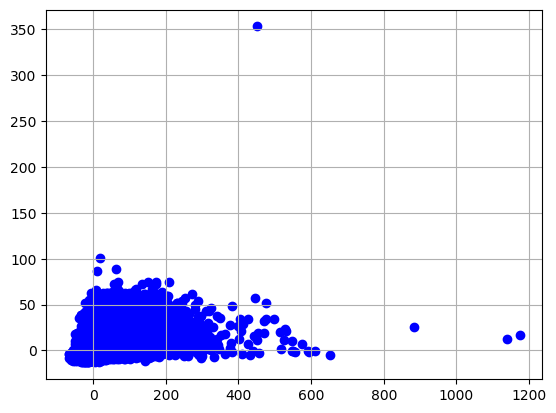

In [15]:
%matplotlib inline

# Plot outputs
import matplotlib.pyplot as plt

# Cleans up the appearance
plt.rcdefaults()

plt.scatter(
  y_test,
  predicted,
  color='blue',
  linewidth=1
)
plt.grid(True)

plt.xticks()
plt.yticks()

plt.show()